In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys, time
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /lustre/work/sunao.sugiyama/package/dark_emulator_public/dark_emulator/__init__.py


## power spectrum class

In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
%%time
power_b1.init_pklin(3.0)

CPU times: user 15.5 ms, sys: 160 µs, total: 15.7 ms
Wall time: 102 ms


In [5]:
%%time
power_b1.init_pkhalo()

CPU times: user 305 ms, sys: 61 µs, total: 305 ms
Wall time: 305 ms


In [6]:
%%time
k = np.logspace(-5.0, 3, 100)
pkhalo = power_b1.get_pkhalo_kz(k, 0.1)
pklin  = power_b1.get_pklin_kz(k, 0.1)

CPU times: user 454 µs, sys: 1.85 ms, total: 2.3 ms
Wall time: 2.23 ms


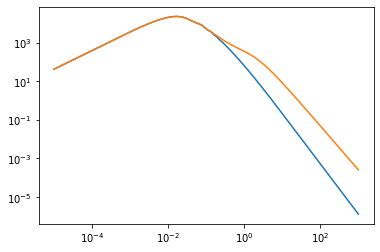

In [7]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e2,1e6)
plt.plot(k, pklin)
plt.plot(k, pkhalo)
plt.show()

$P\left(\frac{l}{\chi}, z(\chi)\right)$

In [8]:
l = 2e3
chimin, chimax = power_b1.z2chi(1e-4), power_b1.z2chi(3)
chi = np.logspace(np.log10(chimin), np.log10(chimax), 50)

In [9]:
%%time
pklin_lz = power_b1.get_pklin_lchi(l, chi)

CPU times: user 2.05 ms, sys: 15 µs, total: 2.07 ms
Wall time: 1.96 ms


In [10]:
%%time
pkhalo_lz = power_b1.get_pkhalo_lchi(l, chi)

CPU times: user 13.4 ms, sys: 124 µs, total: 13.6 ms
Wall time: 12.6 ms


In [11]:
%%time
pkhalogm_lz = power_b1.get_pkhalogm_lchi(l, chi, 4.0)

CPU times: user 12.3 ms, sys: 1.09 ms, total: 13.4 ms
Wall time: 12.5 ms


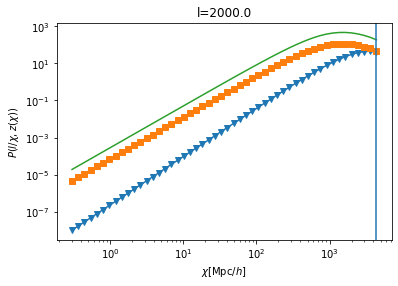

In [12]:
plt.figure()
plt.xlabel(r'$\chi[{\rm Mpc}/h]$')
plt.ylabel(r'$P\left(l/\chi, z(\chi)\right)$')
plt.title(f'l={l}')
plt.loglog(chi, pklin_lz, marker='v')
plt.loglog(chi, pkhalo_lz, marker='s')
plt.loglog(chi, pkhalogm_lz)#, marker='o')
plt.axvline(power_b1.chi_max)
plt.show()

## galaxy sample classes

In [13]:
g_l1 = hsc3x2pt.galaxy_sample_lens_class(['lowz'  , 0.251, 0.15, 0.35, 1.78, '40.36 arcmin^-2', 2.259])
g_l2 = hsc3x2pt.galaxy_sample_lens_class(['cmass1', 0.484, 0.47, 0.55, 2.10, '20.06 arcmin^-2', 3.563])
g_l3 = hsc3x2pt.galaxy_sample_lens_class(['cmass2', 0.617, 0.55, 0.70, 2.28, '30.12 arcmin^-2', 3.729])

g_s1 = hsc3x2pt.galaxy_sample_source_class(['s1' , 1.0, 0.2, '4.37 arcmin^-2'])
g_s2 = hsc3x2pt.galaxy_sample_source_class(['s2' , 1.4, 0.2, '4.37 arcmin^-2'])
g_s12= hsc3x2pt.galaxy_sample_source_class(['s12', 1.2, 0.2, '8.74 arcmin^-2'])

In [14]:
cosmo_dict = power_b1.get_cosmo_dict()
g_l1.set_cosmology_from_dict(cosmo_dict)
g_s1.set_cosmology_from_dict(cosmo_dict)

chirange1 = g_l1.window_galaxy_chirange()
chirange2 = g_s1.window_lensing_chirange()

print(chirange1, chirange2)

[433.352739  959.1119277] [  22.91656451 2268.73988659]


In [15]:
g_l1.z_lens_eff

array(0.23598266)

In [16]:
hsc3x2pt.get_chirange_overlap(chirange1, chirange2)

array([433.352739 , 959.1119277])

In [17]:
g_s1.sample_type

'source'

In [18]:
g_l1.get_shot_noise()

2.0965299787104154e-09

## $C(l)$ class

In [19]:
pk2cl = hsc3x2pt.pk2cl_class(power_b1)

In [20]:
pk2cl.set_galaxy_sample(g_l1)
pk2cl.set_galaxy_sample(g_l2)
pk2cl.set_galaxy_sample(g_l3)
pk2cl.set_galaxy_sample(g_s12)
pk2cl.set_cosmology_from_dict(cosmo_dict)
pk2cl.init_pk()
pk2cl.set_Omega_s({'w':8300, 'gamma_t':140, 'xi':140}) # HSCY1

### $C(l)$ per single l

CPU times: user 37.2 ms, sys: 782 µs, total: 38 ms
Wall time: 37.2 ms


2.0291162349359764e-07

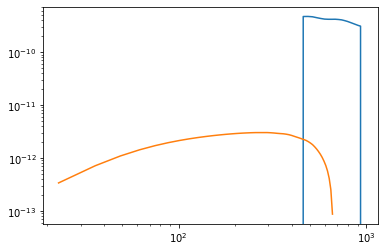

In [21]:
%%time
pk2cl._CgE(g_l1, g_s1, 100, model='nonlin', plot=True, plot_xlog=True)

CPU times: user 25.7 ms, sys: 2.92 ms, total: 28.6 ms
Wall time: 27.9 ms


2.761524668361312e-09

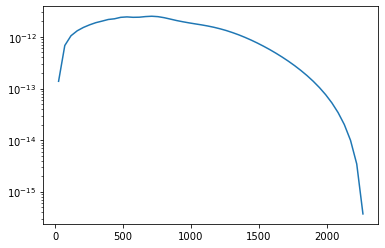

In [22]:
%%time
pk2cl._CEE(g_s1, g_s1, 100.0, model='nonlin', plot=True)

Cgg(l)                                =3.465468484561842e-05
Cgg(l)+Cg,mag(l)                      =3.471248296973003e-05
Cgg(l)+Cg,mag(l)+Cmag,g(l)            =3.477028109384164e-05
Cgg(l)+Cg,mag(l)+Cmag,g(l)+Cmag,mag(l)=3.477233504602964e-05
CPU times: user 55.3 ms, sys: 1.06 ms, total: 56.3 ms
Wall time: 55.4 ms


3.477233504602964e-05

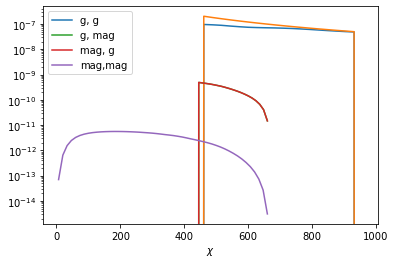

In [23]:
%%time
pk2cl._Cgg(g_l1, g_l1, 100.0, model='nonlin', plot=True)

### $C(l)$ as a function of $l$

lin:1.0558955669403076 sec
nonlin:2.551833152770996 sec


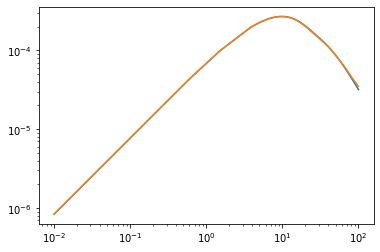

CPU times: user 4.12 s, sys: 61.9 ms, total: 4.18 s
Wall time: 4.17 s


In [24]:
%%time
l = np.logspace(-2, 2.0, 100)

plt.figure()
with hsc3x2pt.Time(message='lin'):
    clgg = pk2cl.Cgg('lowz', 'lowz', l, model='lin')
plt.loglog(l, clgg)
with hsc3x2pt.Time(message='nonlin'):
    clgg = pk2cl.Cgg('lowz', 'lowz', l, model='nonlin', plot=False)
plt.loglog(l, clgg)
plt.show()

lin:0.5225648880004883 sec
lin:1.4815142154693604 sec


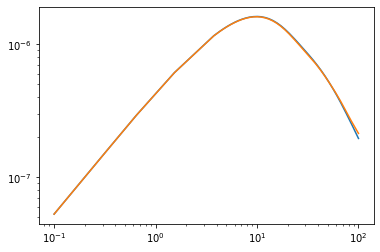

CPU times: user 2.39 s, sys: 43 ms, total: 2.43 s
Wall time: 2.43 s


In [25]:
%%time
l = np.logspace(-1, 2, 1000)

plt.figure()
with hsc3x2pt.Time(message='lin'):
    clgE = pk2cl.CgE('lowz', 's12', l, model='lin')
plt.loglog(l, clgE)
with hsc3x2pt.Time(message='lin'):
    clgE = pk2cl.CgE('lowz', 's12', l, model='nonlin')
plt.loglog(l, clgE)
plt.show()

lin:0.222487211227417 sec
lin:0.8107497692108154 sec


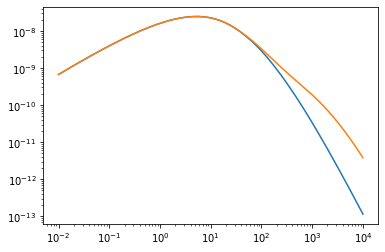

CPU times: user 1.75 s, sys: 83.1 ms, total: 1.84 s
Wall time: 1.83 s


In [26]:
%%time
l = np.logspace(-2, 4, 1000)

plt.figure()
t0 = time.time()
with hsc3x2pt.Time(message='lin'):
    clEE = pk2cl.CEE('s12', 's12', l, model='lin')
plt.loglog(l, clEE)
with hsc3x2pt.Time(message='lin'):
    clEE = pk2cl.CEE('s12', 's12', l, model='nonlin')
plt.loglog(l, clEE)
plt.show()

### compute all the $C(l)$

In [27]:
%%time
l = np.logspace(-2, 5, 1000)
pk2cl.compute_all_Cl(l)

/lustre/work/sunao.sugiyama/weaklensHSCY3Fisher/hsc3x2pt.py:274: RuntimeWarning: divide by zero encountered in true_divide
  k, z = l/chi, self.chi2z(chi)
/lustre/work/sunao.sugiyama/weaklensHSCY3Fisher/hsc3x2pt.py:565: RuntimeWarning: invalid value encountered in true_divide
  ans += simps(w1*w2*plchi/chi**2, chi)
/home/sunao.sugiyama/.local/lib/python3.8/site-packages/scipy-1.6.3-py3.8-linux-x86_64.egg/scipy/integrate/_quadrature.py:397: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/lustre/work/sunao.sugiyama/weaklensHSCY3Fisher/hsc3x2pt.py:588: RuntimeWarning: invalid value encountered in true_divide
  ans += simps(w1*w2*plchi/chi**2, chi) * 2*(alpha_mag1-1)
/lustre/work/sunao.sugiyama/weaklensHSCY3Fisher/hsc3x2pt.py:579: RuntimeWarning: invalid value encountered in true_divide
  ans += simps(w1*w2*plchi/chi**2, chi) * 2*(alpha_mag2-1)


CPU times: user 26.4 s, sys: 13.9 ms, total: 26.4 s
Wall time: 26.3 s


In [28]:
pk2cl.dump_Cl_cache('test_cl', overwrite=True)

saving l to test_cl/l.txt
saving lowz,lowz to test_cl/lowz,lowz.txt
saving lowz,cmass1 to test_cl/lowz,cmass1.txt
saving lowz,cmass2 to test_cl/lowz,cmass2.txt
saving cmass1,lowz to test_cl/cmass1,lowz.txt
saving cmass1,cmass1 to test_cl/cmass1,cmass1.txt
saving cmass1,cmass2 to test_cl/cmass1,cmass2.txt
saving cmass2,lowz to test_cl/cmass2,lowz.txt
saving cmass2,cmass1 to test_cl/cmass2,cmass1.txt
saving cmass2,cmass2 to test_cl/cmass2,cmass2.txt
saving lowz,s12 to test_cl/lowz,s12.txt
saving cmass1,s12 to test_cl/cmass1,s12.txt
saving cmass2,s12 to test_cl/cmass2,s12.txt
saving s12,s12 to test_cl/s12,s12.txt


In [29]:
pk2cl.load_Cl_cache('test_cl')

### Fourier-back transformation of signals

These functions need validation with brute-force method.

brute force:0.05320549011230469 sec
-5.536273882792816 0.5637261172071844


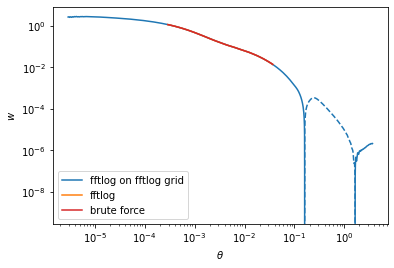

fftlog:0.5823097229003906 sec


In [30]:
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('lowz', 'lowz', t, 'w')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('lowz', 'lowz', t, 'w', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

brute force:0.09778666496276855 sec
-5.536273882792816 0.5637261172071844


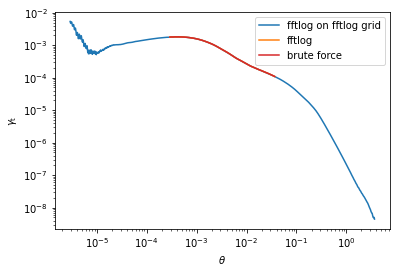

fftlog:0.8742036819458008 sec


In [31]:
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('lowz', 's12', t, 'gamma_t')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('lowz', 's12', t, 'gamma_t', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

brute force:0.05620527267456055 sec
-5.536273882792816 0.5637261172071844


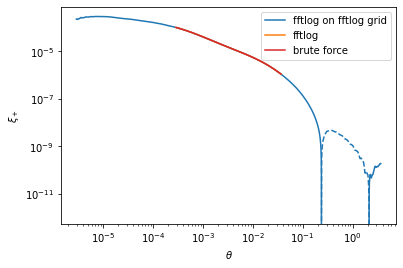

fftlog:0.5891010761260986 sec


In [32]:
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('s12', 's12', t, 'xi+')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('s12', 's12', t, 'xi+', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

brute force:0.09533143043518066 sec
-5.536273882792816 0.5637261172071844


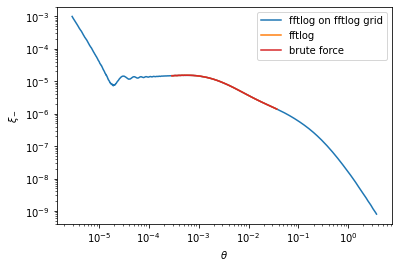

fftlog:0.8913705348968506 sec


In [33]:
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('s12', 's12', t, 'xi-')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('s12', 's12', t, 'xi-', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

### covariance matrices

1000 1000
(1000, 1000)
1000 1000
0.04884271409381313 0.04884271409381313


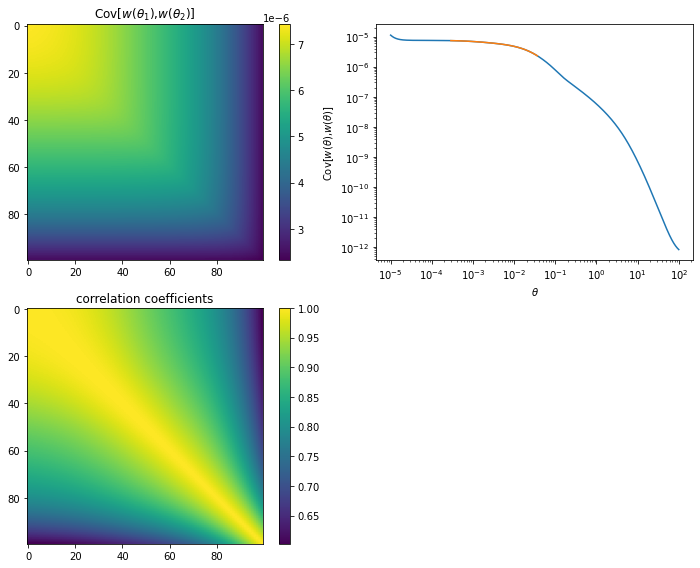

CPU times: user 1.43 s, sys: 186 ms, total: 1.61 s
Wall time: 1.82 s


In [34]:
%%time
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
cov = pk2cl.covariance_fftlog(['lowz','lowz'], 'w', t, ['lowz','lowz'], 'w', t, binave=True, plot=True)

1000 1000
(1000, 1000)
1000 1000
0.04884271409381313 0.04884271409381313


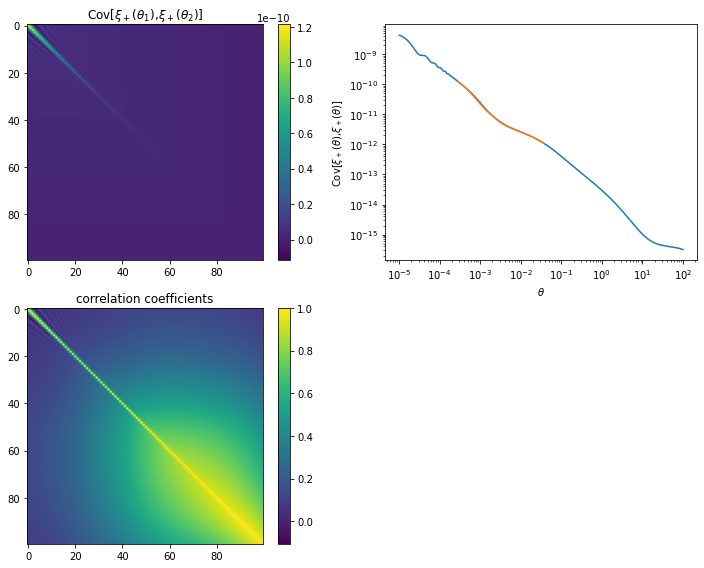

CPU times: user 1.43 s, sys: 162 ms, total: 1.59 s
Wall time: 1.59 s


In [35]:
%%time
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
cov = pk2cl.covariance_fftlog(['s12','s12'], 'xi+', t, ['s12', 's12'], 'xi+', t, binave=True, plot=True)

1000 1000
(1000, 1000)
1000 1000
0.04884271409381313 0.04884271409381313


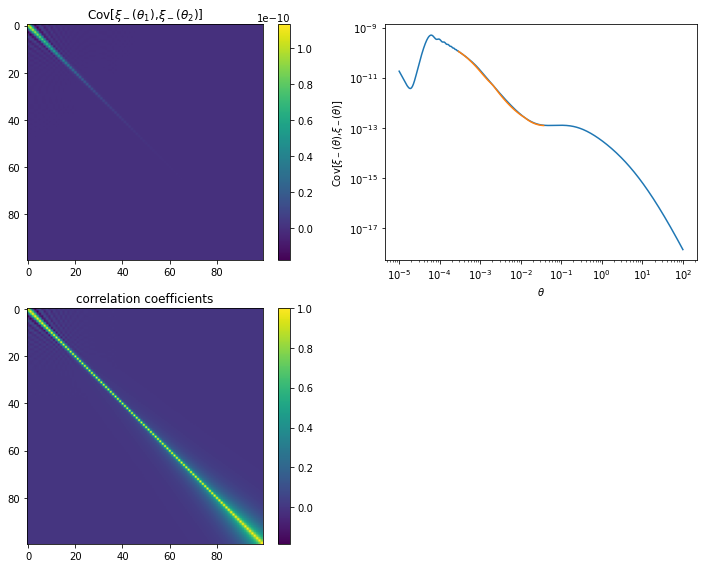

CPU times: user 1.13 s, sys: 129 ms, total: 1.25 s
Wall time: 1.25 s


In [36]:
%%time
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
cov = pk2cl.covariance_fftlog(['s12','s12'], 'xi-', t, ['s12', 's12'], 'xi-', t, binave=True, plot=True)

1000 1000
(1000, 1000)
1000 1000
0.04884271409381313 0.04884271409381313


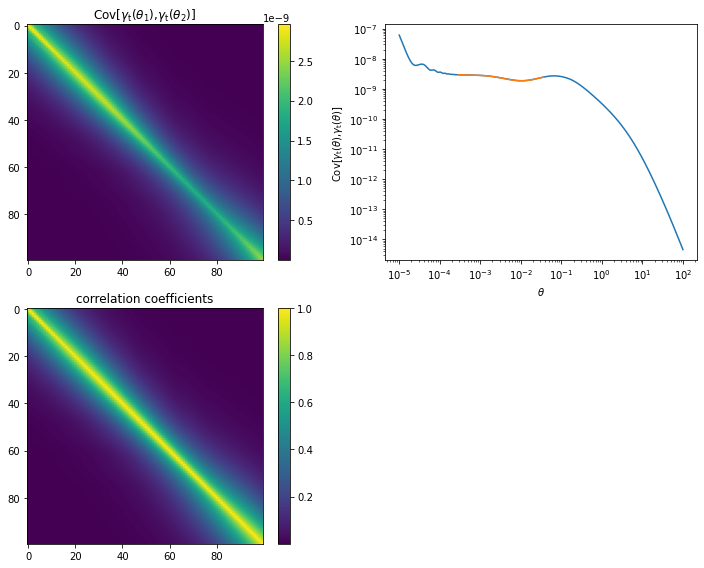

CPU times: user 1.47 s, sys: 154 ms, total: 1.62 s
Wall time: 1.62 s


In [37]:
%%time
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
cov = pk2cl.covariance_fftlog(['lowz','s12'], 'gamma_t', t, ['lowz','s12'], 'gamma_t', t, binave=True, plot=True)

## brute force

0.04884271409381313 0.04884271409381313


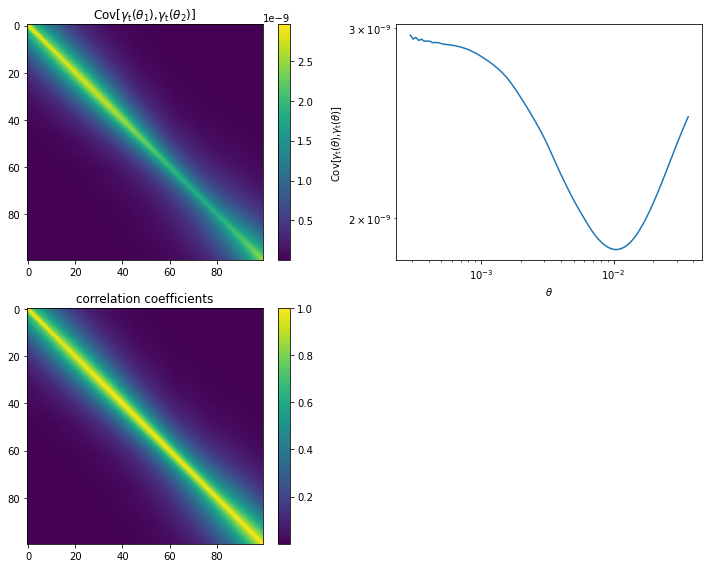

CPU times: user 57.1 s, sys: 61.4 ms, total: 57.2 s
Wall time: 57.2 s


In [38]:
%%time
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
cov = pk2cl.covariance_bruteforce(['lowz','s12'], 'gamma_t', t, ['lowz','s12'], 'gamma_t', t, binave=True, plot=True)

0.04884271409381313 0.04884271409381313


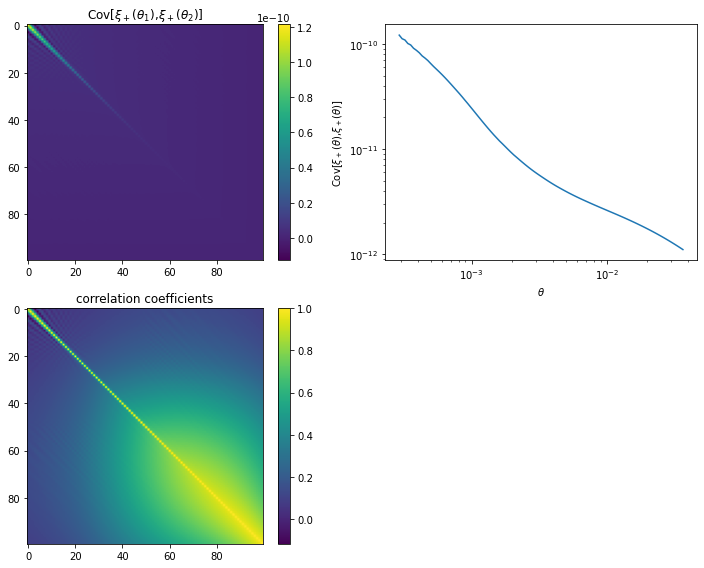

CPU times: user 43.4 s, sys: 71.9 ms, total: 43.5 s
Wall time: 43.5 s


In [39]:
%%time
t = np.logspace(0, 2.1, 100) * hsc3x2pt.arcmin2rad
cov = pk2cl.covariance_bruteforce(['s12','s12'], 'xi+', t, ['s12', 's12'], 'xi+', t, binave=True, plot=True)

### signal and variance (visual check)

-5.536273882792816 0.5637261172071844
1000 1000
(1000, 1000)
1000 1000
0.1667389205271551 0.1667389205271551


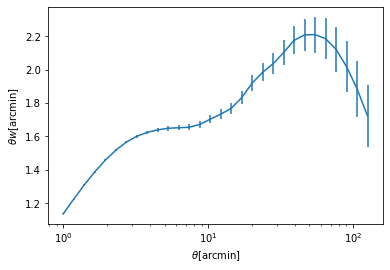

In [40]:
t = np.logspace(0, 2.1, 30) * hsc3x2pt.arcmin2rad
signal = pk2cl.angular_correlation_function_fftlog('lowz', 'lowz', t, 'w')
cov = pk2cl.covariance_fftlog(['lowz','lowz'], 'w', t, ['lowz','lowz'], 'w', t, binave=True)

t_arcmin = t/hsc3x2pt.arcmin2rad
plt.figure()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$\theta w$[arcmin]')
plt.xscale('log')
plt.errorbar(t_arcmin, t_arcmin*signal, t_arcmin*np.diag(cov)**0.5)
plt.show()

-5.536273882792816 0.5637261172071844
1000 1000
(1000, 1000)
1000 1000
0.1667389205271551 0.1667389205271551


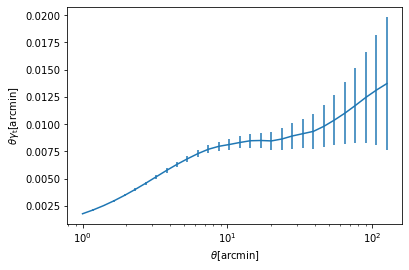

In [41]:
t = np.logspace(0, 2.1, 30) * hsc3x2pt.arcmin2rad
signal = pk2cl.angular_correlation_function_fftlog('lowz', 's12', t, 'gamma_t')
cov = pk2cl.covariance_fftlog(['lowz','s12'], 'gamma_t', t, ['lowz','s12'], 'gamma_t', t, binave=True)

t_arcmin = t/hsc3x2pt.arcmin2rad
plt.figure()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$\theta \gamma_\mathrm{t}$[arcmin]')
plt.xscale('log')
plt.errorbar(t_arcmin, t_arcmin*signal, t_arcmin*np.diag(cov)**0.5)
plt.show()